# Dependencies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn')
from mpl_toolkits import mplot3d
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

# Datasets

In [17]:
def get_normal_data(n=1000, plot=False, xy_features=(2,1)):
    """Get normal dataset of x=(n*4,2), y=(n*4,1)."""
    x0 = np.concatenate([
        np.random.normal(10, 2, size=n),
        np.random.normal(10, 2, size=n),
        np.random.normal(20, 2, size=n),
        np.random.normal(20, 2, size=n),
    ])
    x1 = np.concatenate([
        np.random.normal(30, 2, size=n),
        np.random.normal(40, 2, size=n),
        np.random.normal(30, 2, size=n),
        np.random.normal(40, 2, size=n),
    ])
    y = np.concatenate([
        np.random.normal(50, 2, size=n),
        np.random.normal(60, 2, size=n),
        np.random.normal(70, 2, size=n),
        np.random.normal(80, 2, size=n),
    ])
    data = np.stack((x0, x1, y), axis=1).astype(np.float32)
    np.random.shuffle(data)
    
    if plot:
        ax = plt.axes(projection='3d')
        ax.scatter(data[:,0], data[:,1], data[:,2], alpha=0.3, c='r')
        plt.show()
    
    return (data[:,:2], np.expand_dims(data[:,2], axis=1)) \
            if xy_features == (2,1) else \
            (np.expand_dims(data[:,0], axis=1), data[:,1:])

In [ ]:
def plot_data(X, y):
    """Plot 2D or 3D according to X dimension."""
    if X.shape[1] == 1:
        for i in range(y.shape[1]):
            plt.plot(X, y[:,i], '.')
            plt.show()
    if X.shape[1] == 2:
        for i in range(y.shape[1]):
            ax = plt.axes(projection='3d')
            ax.scatter(X[:,0], X[:,1], y[:,i], c=y[:,i], cmap='viridis')
            plt.show()

X, y shapes: (4000, 2) (4000, 1)


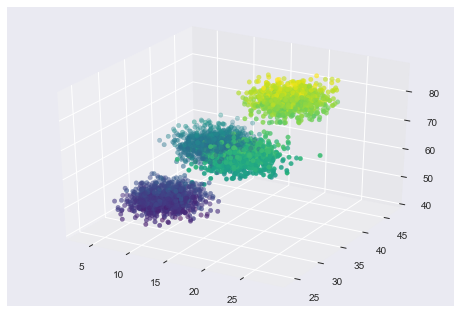

In [18]:
# Use normal dataset
n = 1000
X, y = get_normal_data(n, xy_features=(2,1))
print("X, y shapes:", X.shape, y.shape)

# Plot 2D or 3D graph according to X dimension
plot_data(X, y)

# Convert to TF dataset
n = len(X)
dataset = tf.data.Dataset \
    .from_tensor_slices((X,y)) \
    .shuffle(n).batch(32)

In [ ]:
df = pd.read_csv("data/wholesale.csv")
X = df[['Channel', 'Region']].values.astype(np.float32)
y = df[['Milk']].values.astype(np.float32)

plot_data(X,y)

n = len(X)
batch_size = 32
dataset = tf.data.Dataset \
    .from_tensor_slices((X, y)) \
    .shuffle(n).batch(batch_size)

# Gaussian Mixture Density Network

* Mixing coefficients represented as softmax outputs
* Variances represented as exponentials
* Means represented directly

https://cedar.buffalo.edu/~srihari/CSE574/Chap5/Chap5.6-MixDensityNetworks.pdf

In [19]:
# 1 GMM PER SAMPLE
class GMM:
    """Gaussian Mixture Density Network."""
    def __init__(self, x_features=2, y_features=1, n_components=4, n_hidden=50, verbose=False):
        self.x_features = x_features  # no. of input features
        self.y_features = y_features  # no. of output features
        self.n_components = n_components  # no. of components
        self.n_hidden = n_hidden  # no. of hidden units 
        self.verbose = verbose
        self.build()
    
    def build(self):
        """Compile TF model."""
        input = tf.keras.Input(shape=(self.x_features,))
        layer = tf.keras.layers.Dense(self.n_hidden, activation='tanh')(input)

        mu = tf.keras.layers.Dense(self.n_components * self.y_features)(layer)
        sigma = tf.keras.layers.Dense(self.n_components * self.y_features, activation='exponential')(layer)
        pi = tf.keras.layers.Dense(self.n_components, activation='softmax')(layer)

        self.model = tf.keras.models.Model(input, [pi, mu, sigma])
        self.optimizer = tf.keras.optimizers.Adam()
        
        if self.verbose:
            print(self.model.summary())
        
    def tfdGMM(self, pi, mu, sigma):
        """Tensorflow Probability Distributions GMM."""
        mu = tf.reshape(mu, (self.n_components, self.y_features))
        sigma = tf.reshape(sigma, (self.n_components, self.y_features))
        return tfd.MixtureSameFamily(
            mixture_distribution=tfd.Categorical(probs=pi),
            components_distribution=tfd.MultivariateNormalDiag(loc=mu,
                                                               scale_diag=sigma))

    def loss(self, y, pi, mu, sigma):
        samples = pi.shape[0]
        losses = 0
        for i in range(samples):
            gmm = self.tfdGMM(pi[i], mu[i], sigma[i])
            loss = gmm.log_prob(y[i])
            loss = tf.negative(loss)
            losses += loss
        return losses / samples
    
    @tf.function
    def train_step(self, X, y):
        """TF train function."""
        with tf.GradientTape() as t:
            pi, mu, sigma = self.model(X, training=True)
            loss = self.loss(y, pi, mu, sigma)
        gradients = t.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))
        return loss
    
    def fit(self, dataset, epochs=1000, plot=False):
        """Fit with TF dataset."""
        losses = []
        print_every = int(0.1 * epochs)
        
        for i in range(epochs):
            for train_x, train_y in dataset:
                loss = self.train_step(train_x, train_y)
            losses.append(loss)
            if self.verbose and i % print_every == 0:
                print('Epoch {}/{}: Negative Log-Likelihood {}'.format(i, epochs, losses[-1]))
        
        if plot:
            plt.plot(range(len(losses)), losses)
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.title('Negative Log-Likelihood')
            plt.show()
            
    def prob(self, X, y):
        pi, mu, sigma = self.model(X) 
        samples = pi.shape[0]
        y_prob = []
        for i in range(samples):
            y_prob.append(self.tfdGMM(pi[i], mu[i], sigma[i]).prob(y[i]).numpy())
        return np.array(y_prob)
        
    def predict(self, X):
        pi, mu, sigma = self.model(X) 
        samples = pi.shape[0]
        y_pred = []
        for i in range(samples):
            y_pred.append(self.tfdGMM(pi[i], mu[i], sigma[i]).sample().numpy())
        return np.array(y_pred)
    
    def plot_probability(self, X_fixed, y_range, n_tiles=20):
        X = np.stack([np.full(n_tiles, fill_value=x) for x in X_fixed], axis=1)
        y = np.linspace(y_range[0], y_range[1], n_tiles)

        y_prob = self.prob(X, y)
        plt.title(f"X={X_fixed}, y={y_range}")
        plt.scatter(y, y_prob, c=y_prob, cmap='viridis')
        plt.show()

# Model Training

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 10)           30          input_2[0][0]                    
__________________________________________________________________________________________________
dense_7 (Dense)                 (None, 4)            44          dense_4[0][0]                    
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 4)            44          dense_4[0][0]                    
____________________________________________________________________________________________

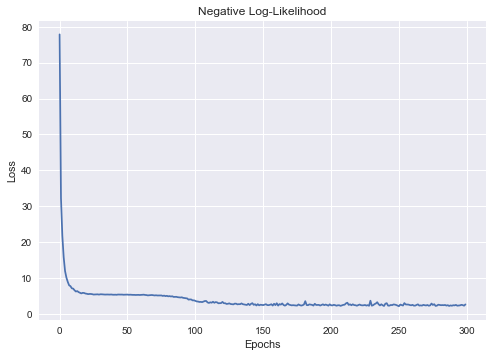

In [20]:
# Build GMM
gmm = GMM(x_features=2,
          y_features=1,
          n_components=4,
          n_hidden=10, verbose=True)
gmm.fit(dataset, epochs=300, plot=True)

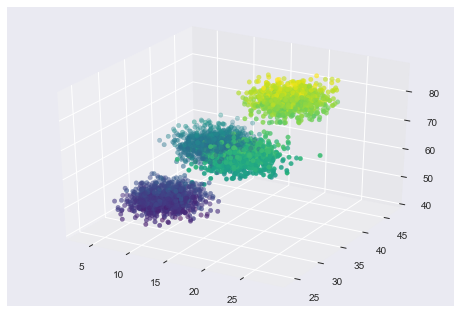

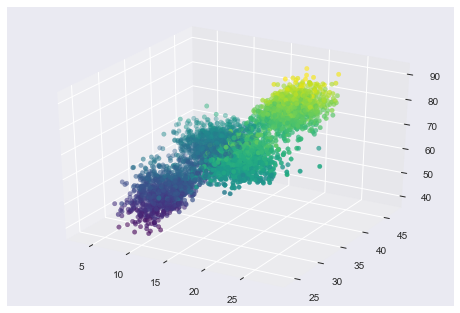

In [21]:
y_hat = gmm.predict(X)
plot_data(X, y)
plot_data(X, y_hat)

# Probability Density Visualisation

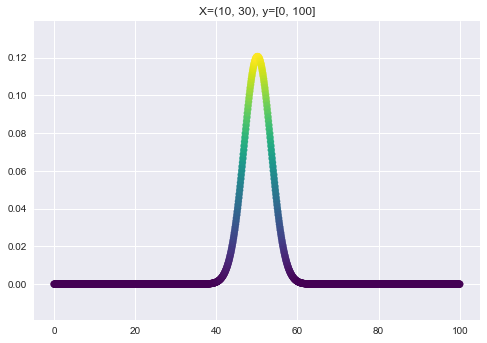

In [24]:
gmm.plot_probability(X_fixed=(10,30), y_range=[0,100], n_tiles=1000)

In [25]:
def plot_density(X1, X2, bins=20):
    pdf, x1, x2 = np.histogram2d(X1, X2, bins=bins, density=True)
    xmesh, ymesh = np.meshgrid(x1[:-1], x2[:-1])
    ax = plt.axes(projection='3d')
    ax.plot_surface(xmesh, ymesh, pdf, cmap='viridis')
    plt.show()
    return pdf

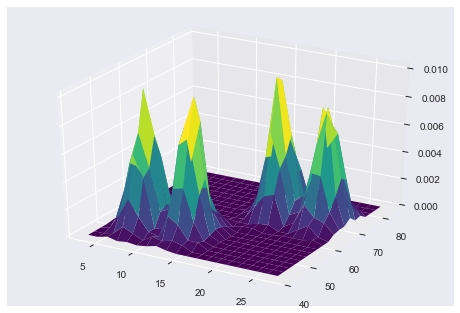

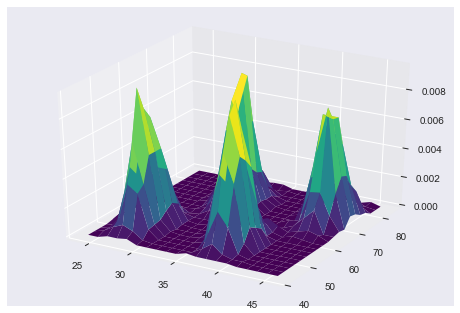

In [26]:
pdf_x1 = plot_density(X[:,0], y[:,0], bins=20)
pdf_x2 = plot_density(X[:,1], y[:,0], bins=20)

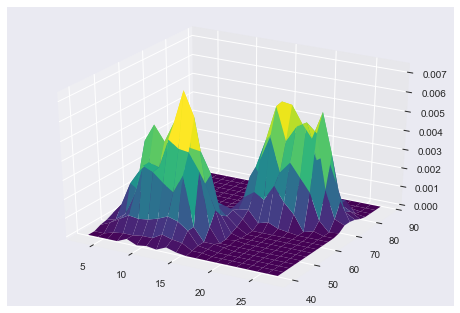

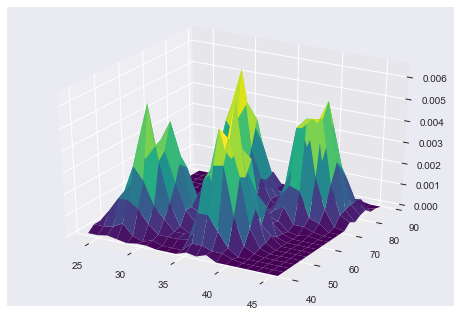

In [27]:
pdf_x1_pred = plot_density(X[:,0], y_hat[:,0], bins=20)
pdf_x2_pred = plot_density(X[:,1], y_hat[:,0], bins=20)

# Distance Metrics

In [237]:
def kl_divergence(p, q):
    return np.sum(np.where(p != 0, p * np.log(p / q), 0))